## Introduction

In this post, I would like to describe full story of my experiences in spatial downscaling of MERRA-2 data. The main spark of using MERRA-2 data refers to the paper of *`Assessment of drought conditions over Vietnam using standardized precipitation evapotranspiration index, MERRA-2 re-analysis, and dynamic land cover (Manh-Hung Le et al., 2020)`*. Researchers of this paper used spatial rescaled MERRA-2 data from ~50-km to ~1-km and used it for calculation of drought index.

In first step, I tried to use [Land surface Data Toolkit (LDT)](https://lis.gsfc.nasa.gov/documentation/ldt). So, based on LDT [User Guide](https://lis.gsfc.nasa.gov/sites/default/files/LIS/public_7_3_releases/LDT_usersguide.21-dec-2020.html), required libraries were installed for setup LDT in personal laptop. Although successfully installation of all necessary libraries in a hard way, but I didn't success in using LDT to spatial downscaling of MERRA-2 data.

After unsuccessful attempts to use LDT correctly, connection with authors of mentioned paper was seemed a right way. Dr. Hyunglok Kim as one of the paper's researches warned me that their spatial downscaled of MERRA-2 data was generated from the [Land Information System (LIS)](https://lis.gsfc.nasa.gov/), not LDT. Specifically, the LDT will just produce some basic information to produce data from LIS. Based on Hyung explanation about producing spatial rescaled data, me seemed to need a supercomputer to do that. With the help of Hyung, temperature and rain monthly data from 2000 to 2020 produced in 0.001 degree (~1 km) of spatial resolution. In the following, the procedure of analysis of this data will describe.

## Overall view of data

Spatial downscaled of MERRA-2 data files was in `NetCDF` format. So, me preferred to use `Xarray` python library to check some its properties.

Opening 252 NetCDF files simultaneously will done with some python libraries. 

In [ ]:
#collapse

# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

ModuleNotFoundError: No module named 'xarray'

Reading files:

In [ ]:
#hide
ds = xr.open_mfdataset("/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/monthly_data/*.nc")

In [ ]:
#collapse_output
print(ds)

<xarray.Dataset>
Dimensions:           (time: 252, north_south: 701, east_west: 1001, ensemble: 1)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
  * ensemble          (ensemble) float32 1.0
Dimensions without coordinates: north_south, east_west
Data variables:
    lat               (time, north_south, east_west) float32 dask.array<chunksize=(1, 701, 1001), meta=np.ndarray>
    lon               (time, north_south, east_west) float32 dask.array<chunksize=(1, 701, 1001), meta=np.ndarray>
    Rainf_f_tavg      (time, ensemble, north_south, east_west) float32 dask.array<chunksize=(1, 1, 701, 1001), meta=np.ndarray>
    Rainf_f_inst      (time, ensemble, north_south, east_west) float32 dask.array<chunksize=(1, 1, 701, 1001), meta=np.ndarray>
    Tair_f_tavg       (time, ensemble, north_south, east_west) float32 dask.array<chunksize=(1, 1, 701, 1001), meta=np.ndarray>
    Tair_f_inst       (time, ensemble, north_south, east_west) float32 dask.a

Output reading fils show that thera are <u>time, north_south, east_west, ensemble</u> as ***Dimensions***, <u>time</u> and <u>ensemble</u> as ***Coordinates*** and <u>lat, lon, Rainf_f_tavg, Rainf_f_inst, Tair_f_tavg, Tair_f_inst, TotalPrecip_tavg, TotalPrecip_inst</u> as ***Data variables*** of data.

You can see all of these items individually as follow:

In [ ]:
#collapse_output
ds.dims

Frozen({'time': 252, 'north_south': 701, 'east_west': 1001, 'ensemble': 1})

In [ ]:
#collapse_output
ds.coords

Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
  * ensemble  (ensemble) float32 1.0

In [ ]:
#collapse_output
ds.variables

Frozen({'lat': <xarray.Variable (time: 252, north_south: 701, east_west: 1001)>
dask.array<concatenate, shape=(252, 701, 1001), dtype=float32, chunksize=(1, 701, 1001), chunktype=numpy.ndarray>
Attributes:
    units:          degree_north
    standard_name:  latitude
    long_name:      latitude
    vmin:           0.0
    vmax:           0.0, 'lon': <xarray.Variable (time: 252, north_south: 701, east_west: 1001)>
dask.array<concatenate, shape=(252, 701, 1001), dtype=float32, chunksize=(1, 701, 1001), chunktype=numpy.ndarray>
Attributes:
    units:          degree_east
    standard_name:  longitude
    long_name:      longitude
    vmin:           0.0
    vmax:           0.0, 'time': <xarray.IndexVariable 'time' (time: 252)>
array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes

In [ ]:
#collapse_output
ds.attrs

{'missing_value': -9999.0,
 'NUM_SOIL_LAYERS': 4,
 'SOIL_LAYER_THICKNESSES': array([0.1, 0.3, 0.6, 1. ], dtype=float32),
 'title': 'LIS land surface model output',
 'institution': 'NASA GSFC',
 'source': '+template open water',
 'history': 'created on date: 2021-07-10T04:31:27.879',
 'references': 'Kumar_etal_EMS_2006, Peters-Lidard_etal_ISSE_2007',
 'conventions': 'CF-1.6',
 'comment': 'website: http://lis.gsfc.nasa.gov/',
 'MAP_PROJECTION': 'EQUIDISTANT CYLINDRICAL',
 'SOUTH_WEST_CORNER_LAT': 27.0,
 'SOUTH_WEST_CORNER_LON': 47.0,
 'DX': 0.01,
 'DY': 0.01}

It is possible to show items for a dimension of our dataset that can be useful in future analysis.

In [ ]:
#collapse_output
print(ds.time)

<xarray.DataArray 'time' (time: 252)>
array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
Attributes:
    long_name:       time
    time_increment:  2592000
    begin_date:      20000101
    begin_time:      000000


## Simple Plotting

`Xarray` library in combination of `matplotlib` library has powerful capability to draw various plots. For example in section will show some plots with xarray. Dataset variables show there are three climate variables include `air temperature`, `rainfall` and `total precipitation`. We can plot `air temperature` in first time as follow.

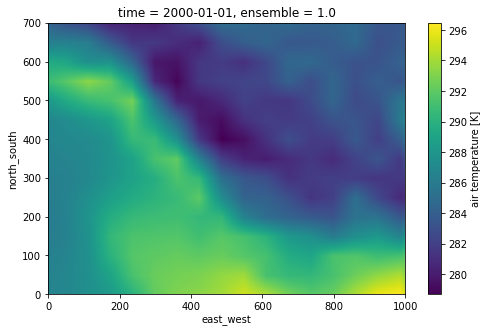

In [ ]:
#collapse
temp = ds.Tair_f_tavg
temp[0].plot();

There is another way to plot based on specific time.

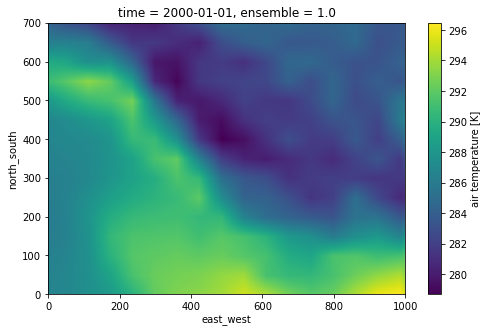

In [ ]:
#hide_output
temp = ds.Tair_f_tavg
temp.sel(time='2000-01-01').plot();

Despite there are `lat` and `lon` data variables in dataset, in above plot geographical coordinates have been displayed incorrectly. Because `lat` and `lon` are not as `dimension`, we can not display geographical coordinates correctly. For improve the plot in showing geographical coordinates, mentioned data variables should be set as coords. Furthermore, `air temperature` unit is in `kelvin [K]`, while we need it as `celsius [C]`. So it is necessary to convert air temperature unit.

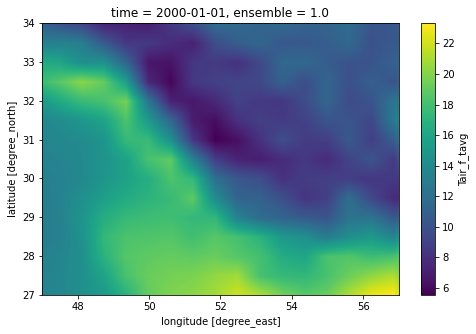

In [ ]:
#collapse

# set `lat` and `lon` as coords
ds = ds.set_coords(['lon','lat'])

# convert `air temperature` unit from kelin to celsius
temp_c = ds.Tair_f_tavg - 273.15

# plotting `air temperature` data variable in celsius and geographical coordinates.
temp_c.sel(time='2000-01-01').plot(x='lon', y='lat');

## Simple statistics

Now, with new dataarray created for `air temperature` it is possible to compute some statistics for this climate variable such as `mean`, `std`, `min`, `max`, etc. For example, some air temperature statistics for August 2015 are shown as follow.

In [ ]:
#collapse
temp_20150825 = temp_c.sel(time='2015-08-01')
temp_avg = temp_20150825.mean().values
temp_std = temp_20150825.std().values
temp_min = temp_20150825.min().values
temp_max = temp_20150825.max().values

print("Mean air temperature for August 2015 is", temp_avg , "celsius.\n"
     "Standard deviation of air temperature for August 2015 is", temp_std ,".\n"
     "Minimum air temperature for August 2015 is", temp_min , "celsius.\n"
     "Maximum air temperature for August 2015 is", temp_max , "celsius.")

Mean air temperature for August 2015 is 31.591408 celsius.
Standard deviation of air temperature for August 2015 is 4.980299 .
Minimum air temperature for August 2015 is 21.36026 celsius.
Maximum air temperature for August 2015 is 40.377167 celsius.


> Tip: Our data is monthly from 2000 to 2020..

## Certain point values

The Merre-2 rescaled data is a reanalysis data with contiguous values, so if we want to compare this values with climatic station data as ground values it is important to extract the climate variables from Merra-2 dataset in a specific values in accordance with climatic station latitude and longitude. For extract this value(s) based on certain latitude and longitude we can finding the index of the grid point nearest a specific lat/lon. 

In this example we want to find air temperature in latitude = 30.66 and longitude = 51.58 for August 2015.

In [ ]:
#collapse

latitude = 30.66
longitude = 51.58

#finding the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(temp_20150825.lat-latitude)
abslon = np.abs(temp_20150825.lon-longitude)
c = np.maximum(abslon, abslat)
([xloc], [yloc]) = np.where(c == np.min(c))

# Using that index location to get the values at the x/y diminsion
point_ds = ds.sel(north_south=xloc, east_west=yloc)

# Value of certain point in celsius
temp_pnt = point_ds.sel(time='2015-08-01').Tair_f_tavg.values- 273.15
print("The monthly air temperature in August 2015 for latitude=", latitude, " and longitude=", longitude, "is", format(float(temp_pnt), '.2f'), "celsius.")

The monthly air temperature in August 2015 for latitude= 30.66  and longitude= 51.58 is 25.74 celsius.


We can also plot for this point in August 2015.

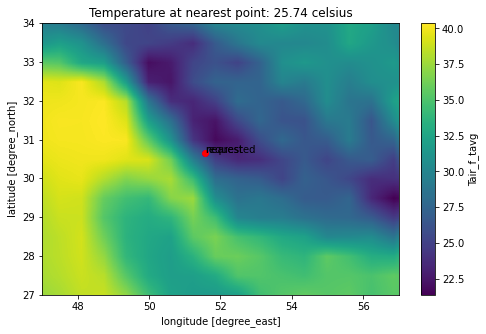

In [ ]:
#collapse

# Plot requested lat/lon point blue
temp_20150825.plot(x='lon', y='lat')
plt.scatter(longitude, latitude, color='b')
plt.text(longitude, latitude, 'requested')

# Plot nearest point in the array red
plt.scatter(point_ds.lon[0], point_ds.lat[0], color='r')
plt.text(point_ds.lon[0], point_ds.lat[0], 'nearest')
plt.title('Temperature at nearest point: %s celsius' % format(float(temp_pnt), '.2f'));

The mean monthly temperature for all time series can also be calculated.

In [ ]:
#collapse

# Mean temperature average for specifiv lat/lon
pnt = point_ds.Tair_f_tavg.values - 273.15
print("The monthly air temperature from 2000 to 2020 for latitude=", latitude, " and longitude=", longitude, "is", format(float(pnt.mean()), '.2f'), "celsius.")

The monthly air temperature from 2000 to 2020 for latitude= 30.667  and longitude= 51.583 is 14.65 celsius.


## Swap "north_south" and "east_west" dimensions with "lat" and "lon" coordinates

One of the perbolem in working with this dataset is about latitude/longitude. As you saw before there is not any dimension related latitude and longitude and we used `set_coords` to define `lat` and `lot` data variables to plot correctly in geographical coordinates while dataset did not any change in inherent and do any analysis related to latitude and longitude of dataset will have challenges. So, it's best suggestion to create new dataset with raw data that have latitude and longitude dimensions. Two dimensions include `north_south` and `east_west` are linespaces related to latitude and longitude. In this dimensions, from beginning to ending latitude divide based on 0.001 degree distances that first value for `north_south` set to zero and last value will be based on dividing distances. For example for this dataset zero value of `north_south` is equal minimum latitude (27.0 degree) and last value (700) is equal maximum latitude (34.0 degree). The `east_wet` dimension values is also same as `north_south` but for longitude. So, if we can swap the `north_south` and `east_west` dimensions values with original `latitude` and `longitude`, respectively, we will have new dataset with original latitude and longitude dimensions.

For swapping "north_south" and "east_west" dimensions with `lat` and `lon` coordinates there is a `Regridder` function in `xesmf` library. Because of multiple NetCDF files should be regridded, so it's better to done it in a loop.

Although input netcdf files have small size but output netcdf files exported from `xarray` dataset will be more than x9-10 larger, so for solve this challenge we use `zarr` library to save output regridded files. But if drop unuseful data variables such as 'Rainf_f_inst', 'Tair_f_inst', 'TotalPrecip_inst' and set remain data variables data type as `float32`, we can save output file in netcdf format with smaller size.

In [ ]:
#collapse

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import zarr
import warnings
warnings.filterwarnings('ignore')

# reading dataset
ds = xr.open_mfdataset("/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/MERRA_2/monthly_data/*.nc")
ds = ds.set_coords(['lon','lat'])

# definign outout path
path_output = '/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/MERRA_2/monthly_data/monthly_regrid2/'

# regriding loop
for i in range (0, len(ds.time)):
    dsi = ds.sel(time = ds.time[i])
    
    # swap dimensions with multi-dimensional coordinates
    ds_xy_grid = dsi.rename(north_south='lat', east_west='lon')
    ds_out = xr.Dataset({'lat': (['lat'], np.linspace(27.0, 34.0, 701)),
                     'lon': (['lon'], np.linspace(47.0, 57.0, 1001))})
    
    regridder = xe.Regridder(ds_xy_grid, ds_out, method='bilinear')
    ds_lonlat_grid = regridder(ds_xy_grid)
    ds_lonlat_grid = ds_lonlat_grid.rename(lat='latitude', lon='longitude')
    
    # Removing some zero values for plotting correctly
    ds_lonlat_grid = ds_lonlat_grid.where(ds_lonlat_grid['Tair_f_tavg'] > 0.01, drop=True)
    ds_lonlat_grid.attrs = dsi.attrs
    droped = ds_lonlat_grid.drop_vars(['Rainf_f_inst', 'Tair_f_inst', 'TotalPrecip_inst'])
    
    # Take date time for name of output file
    time = str(ds_lonlat_grid.time.values)
    time = time.removesuffix('T00:00:00.000000000')
    
    # save to netcdf
    encoding = {'Rainf_f_tavg':{'zlib': True, 'complevel': 5, 'dtype': 'float32'},
                'Tair_f_tavg':{'zlib': True, 'complevel': 5, 'dtype': 'float32'},
                'TotalPrecip_tavg':{'zlib': True, 'complevel': 5, 'dtype': 'float32'}}
    
    droped.to_netcdf((path_output + "regrid_merra_" + time + ".nc"),encoding=encoding)
    
    del ds_xy_grid, ds_out, regridder, ds_lonlat_grid, time, encoding, droped

### Improved Above Code
NOTE: The below code in Jupyterlab app desktop with python 8 did not work correctly but it worked in jupyterlab in browser with python 3.9.5 correctly.

In [ ]:
# reading dataset
ds = xr.open_mfdataset("/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/MERRA_2/monthly_data/*.nc")
ds = ds.set_coords(['lon','lat'])

# definign outout path
path_output = '/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/MERRA_2/monthly_data/monthly_regrid3/'

# regriding loop
for i in range (0, len(ds.time)):
    dsi = ds.sel(time = ds.time[i])
    
    # swap dimensions with multi-dimensional coordinates
    ds_xy_grid = dsi.rename(north_south='lat', east_west='lon')    
    ds_out = xr.Dataset({'lat': (['lat'], np.linspace(27.0, 34.0, 701)),
                     'lon': (['lon'], np.linspace(47.0, 57.0, 1001))})
    
    regridder = xe.Regridder(ds_xy_grid, ds_out, method='bilinear')
    ds_lonlat_grid = regridder(ds_xy_grid)
    ds_lonlat_grid = ds_lonlat_grid.rename(lat='latitude', lon='longitude')
    
    # Removing some zero values for plotting correctly
    ds_lonlat_grid = ds_lonlat_grid.where(ds_lonlat_grid['Tair_f_tavg'] > 0.01, drop=True)
    #dropnan1 = ds_lonlat_grid.dropna('longitude', how = 'any')
    #dropnan2 = dropnan1.dropna('latitude', how = 'any')
    ds_lonlat_grid.attrs = dsi.attrs
    droped = ds_lonlat_grid.drop_vars(['Rainf_f_inst', 'Tair_f_inst', 'TotalPrecip_inst'])
    expanded_da = xr.concat([droped], 'time') # add 'time' dimension
    #resample_monthly = expanded_da.resample(time='1M').max()
    final_ds = expanded_da.squeeze(dim='ensemble', drop=False) # drop 'ensemble' dimension
    
    # Take date time for name of output file
    time = str(ds_lonlat_grid.time.values)
    time = time.removesuffix('T00:00:00.000000000')
    
    # save to netcdf
    encoding = {'Rainf_f_tavg':{'zlib': True, 'complevel': 5, 'dtype': 'float32'},
                'Tair_f_tavg':{'zlib': True, 'complevel': 5, 'dtype': 'float32'},
                'TotalPrecip_tavg':{'zlib': True, 'complevel': 5, 'dtype': 'float32'}}
    
    final_ds.to_netcdf((path_output + "regrid_merra_" + time + ".nc"),encoding=encoding)
    
    del ds_xy_grid, ds_out, regridder, ds_lonlat_grid, time, encoding, droped, expanded_da, final_ds

Comparison between raw and regreded MERRA-2 data are plotted in below. The July 2009 selected for comparison.

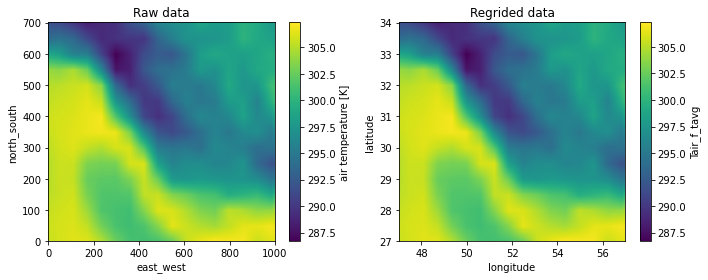

In [ ]:
# collapse

ds_raw = xr.open_dataset('/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/monthly_data/LIS_HIST_200906010000.d01.nc')
ds_reg = xr.open_dataset('/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/monthly_data/monthly_regrid/regrid_merra_2009-06-01.nc')

# Compare two plots
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

ds_raw.Tair_f_tavg.plot(ax=axes[0])
axes[0].set_title("Raw data")

ds_reg.Tair_f_tavg.plot(ax=axes[1])
axes[1].set_title("Regrided data")

fig.tight_layout()

Now we can select a random point in above plots and extract its air temperature and rain values for more exactly comparison.

In [ ]:
# collapse

# defining a random point for extract climatic variables
latitude = 30.48
longitude = 50.58

# raw data
abslat = np.abs(ds_raw.lat-latitude)
abslon = np.abs(ds_raw.lon-longitude)
c = np.maximum(abslon, abslat)
([xloc], [yloc]) = np.where(c == np.min(c))
pnt_raw = ds_raw.sel(north_south=xloc, east_west=yloc)
temp_raw = pnt_raw.Tair_f_tavg.values
rain_raw = pnt_raw.Rainf_f_tavg.values

# regrided data
pnt_reg = ds_reg.where((ds_reg.longitude==longitude) & (ds_reg.latitude==latitude), drop=True)
temp_reg = pnt_reg.Tair_f_tavg.values
rain_reg = pnt_reg.Rainf_f_tavg.values

print("The air temperature in raw Merra-2 is ", format(float(temp_raw), '.2f'),"\n"
     "The air temperature in regrided Merra-2 is ", format(float(temp_reg), '.2f'),"\n"
     "The rain in raw Merra-2 is ", format(float(rain_raw), '.2f'),"\n"
     "The rain in regrided Merra-2 is ", format(float(rain_reg), '.2f'))

The air temperature in raw Merra-2 is  303.64 
The air temperature in regrided Merra-2 is  303.64 
The rain in raw Merra-2 is  0.00 
The rain in regrided Merra-2 is  0.00


## Integrated Surface Dataset (Global)

Our data preparation till here was about MERRA-2 dataset. As mentioned earlier, MERRA-2 data type is reanalysis data, since we downscaled this data  spatially, verifying this data with real data is necessary. The best database for real hourly climate variables is [The Integrated Surface Dataset (ISD)](https://www.ncei.noaa.gov/access/search/data-search/global-hourly). According to its website, `ISD` is composed of worldwide surface weather observations from over 35,000 stations, though the best spatial coverage is evident in North America, Europe, Australia, and parts of Asia. Parameters included are: air quality, atmospheric pressure, atmospheric temperature/dew point, atmospheric winds, clouds, precipitation, ocean waves, tides and more. ISD refers to the data contained within the digital database as well as the format in which the hourly, synoptic (3-hourly), and daily weather observations are stored. ISD provides hourly data that can be used in a wide range of climatological applications. For some stations, data may go as far back as 1901, though most data show a substantial increase in volume in the 1940s and again in the early 1970s. Currently (2021-08-17), there are over 14,000 "active" stations updated daily in the database.

In our study area boundary, there is 20 stations for surface weather observations. The air temperature and rainfall was downloaded for this stations in target time period. This data need preparation to use in analysis. The `vaex` library is a useful python package for work with large data with low memory usage. We used this library for preparation of surface weather data.

In [ ]:
#collapse_output

import vaex
dfv = vaex.from_csv('/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/2654018.csv')
dfv

/home/nilik/MYPROGRAMS/miniconda3/envs/envinfo/lib/python3.9/site-packages/vaex/__init__.py:524: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  return _from_csv_read(filename_or_buffer=filename_or_buffer, copy_index=copy_index,


#,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,TMP
0,40875099999,"BANDAR ABBASS INTERNATIONAL, IR",27.218169,56.377875,6.7,2000-01-01T00:00:00,4,FM-12,OIKB,V020,"+0142,1"
1,40875099999,"BANDAR ABBASS INTERNATIONAL, IR",27.218169,56.377875,6.7,2000-01-01T07:00:00,4,FM-15,OIKB,V020,"+0260,1"
2,40875099999,"BANDAR ABBASS INTERNATIONAL, IR",27.218169,56.377875,6.7,2000-01-01T08:00:00,4,FM-15,OIKB,V020,"+0280,1"
3,40875099999,"BANDAR ABBASS INTERNATIONAL, IR",27.218169,56.377875,6.7,2000-01-01T09:00:00,4,FM-15,OIKB,V020,"+0290,1"
4,40875099999,"BANDAR ABBASS INTERNATIONAL, IR",27.218169,56.377875,6.7,2000-01-01T10:00:00,4,FM-15,OIKB,V020,"+0300,1"
...,...,...,...,...,...,...,...,...,...,...,...
"2,480,209",40836199999,"PERSIAN GULF AIRPORT, IR",27.3666666,52.7333333,8.0,2020-12-31T14:00:00,4,FM-15,99999,V020,"+0220,1"
"2,480,210",40836199999,"PERSIAN GULF AIRPORT, IR",27.3666666,52.7333333,8.0,2020-12-31T15:00:00,4,FM-15,99999,V020,"+0200,1"
"2,480,211",40836199999,"PERSIAN GULF AIRPORT, IR",27.3666666,52.7333333,8.0,2020-12-31T16:00:00,4,FM-15,99999,V020,"+0180,1"
"2,480,212",40836199999,"PERSIAN GULF AIRPORT, IR",27.3666666,52.7333333,8.0,2020-12-31T17:00:00,4,FM-15,99999,V020,"+0160,1"


The name of surface weather stations are:

In [ ]:
# collapse
dfv.NAME.unique()

['BANDAR ABBASS INTERNATIONAL, IR',
 'KERMAN, IR',
 'RAFSANJAN, IR',
 'LAMERD, IR',
 'SIRJAN, IR',
 'BUSHEHR, IR',
 'SHIRAZ SHAHID DASTGHAIB INTERNATIONAL, IR',
 'JAM, IR',
 'FASA, IR',
 'YASOGE, IR',
 'ABADEH, IR',
 'BANDAR E DAYYER, IR',
 'BAFT, IR',
 'GACHSARAN, IR',
 'LAR, IR',
 'FARSI ISLAND, IR',
 'YASOUJ, IR',
 'KHARG, IR',
 'ASALOYEH, IR',
 'PERSIAN GULF AIRPORT, IR']

Some columns in this data should be changed, you can see preparation commands in follow.

Counting values for each station:

In [ ]:
# collapse_output
station_count = dfv.groupby(by='NAME').agg({'count':'count'})
for x in range(len(station_count)):
    print (station_count[x])

['BUSHEHR, IR', 267359]
['YASOGE, IR', 9650]
['JAM, IR', 54130]
['BANDAR E DAYYER, IR', 33972]
['FASA, IR', 190922]
['YASOUJ, IR', 166293]
['BAFT, IR', 53720]
['GACHSARAN, IR', 149147]
['ASALOYEH, IR', 2]
['SHIRAZ SHAHID DASTGHAIB INTERNATIONAL, IR', 407263]
['KHARG, IR', 74317]
['PERSIAN GULF AIRPORT, IR', 97346]
['LAR, IR', 152458]
['FARSI ISLAND, IR', 15]
['BANDAR ABBASS INTERNATIONAL, IR', 335261]
['ABADEH, IR', 110148]
['LAMERD, IR', 32682]
['KERMAN, IR', 273070]
['RAFSANJAN, IR', 18811]
['SIRJAN, IR', 53648]


Checking temperature column data type:

In [ ]:
# collapse_output
dfv['TMP'].data_type

<bound method Expression.data_type of Expression = TMP
Length: 2,480,214 dtype: string (column)
----------------------------------------
      0  +0142,1
      1  +0260,1
      2  +0280,1
      3  +0290,1
      4  +0300,1
      ...       
2480209  +0220,1
2480210  +0200,1
2480211  +0180,1
2480212  +0160,1
2480213  +0150,1
>

It's need to be changed the temperature column data type from string to float. So, the 'Temp' column values was splitted and then was built new temperature column with correct values.

In [ ]:
# collapse_output
dfv['Temp_C'] = dfv["TMP"].str.split(",").apply(lambda x: x[0])
dfv['Temp_C'].astype('float32')

Expression = astype(Temp_C, 'float32')
Length: 2,480,214 dtype: float32 (expression)
---------------------------------------------
      0  142
      1  260
      2  280
      3  290
      4  300
    ...     
2480209  220
2480210  200
2480211  180
2480212  160
2480213  150

Then, we convert temperature values to celsius degree.

In [ ]:
#collapse_output
dfv['Temp_C_2'] = (dfv['Temp_C'].astype('float32'))/10

Checking DATA column data type:

In [ ]:
# collapse_output
dfv.DATE.data_type

<bound method Expression.data_type of Expression = DATE
Length: 2,480,214 dtype: string (column)
----------------------------------------
      0  2000-01-01T00:00:00
      1  2000-01-01T07:00:00
      2  2000-01-01T08:00:00
      3  2000-01-01T09:00:00
      4  2000-01-01T10:00:00
            ...             
2480209  2020-12-31T14:00:00
2480210  2020-12-31T15:00:00
2480211  2020-12-31T16:00:00
2480212  2020-12-31T17:00:00
2480213  2020-12-31T18:00:00
>

The data type of DATA column should be in datetime64 format, so it was changed.

In [ ]:
# collapse
dfv['DATE']=dfv.DATE.astype('datetime64[ns]')

After finalizing preparation of surface data observations, it was saved as a new CSV file.

In [ ]:
# collpase
dfv.export_csv("/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/improved_stations.csv")

## Comparison of MERRA-2 data with surface data observation data

After regriding MERRA-2 data and cleaning surface observation data, we can compare these data based on station latitude and longitude. For example we want to compare air temperature in Shiraz station for November 2018.

In [ ]:
# collapse

# Import libraries
import vaex
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import warnings
warnings.filterwarnings('ignore')

# Opening surface data observations
dfv = vaex.from_csv('/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/improved_stations.csv')

# Opening Merra-2 data
ds = xr.open_mfdataset("/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/monthly_data/*.nc")
ds = ds.set_coords(['lon','lat'])

########## Extracting data from surface weather observation data ##########

# Changing 'DATE' column data type from string to datetime64 
dfv['DATE']=dfv.DATE.astype('datetime64[ns]')

# Filtering dataframe based on 'NAME' column
station_name = 'LAMERD, IR'
station = dfv[dfv.NAME == str(station_name)]

# Select a certain month data
start_date = np.datetime64('2018-11-01 00:00:00')
end_date = np.datetime64('2018-11-30 23:00:00')

startDATE = station[(station.DATE > start_date)]
rangeDATE = startDATE[(startDATE.DATE < end_date)]

# Drop nan values (999.9)
edit = rangeDATE[rangeDATE.Temp_C < np.float64(100)]

# Calculate monthly mean temperature for 2018-11
trmp_2018_11 = edit.mean(edit['Temp_C'])

# Print surface monthly air temperature
print('Surface monthly air temperature for [', station_name, '] is: ', format(float(trmp_2018_11), '.2f'))

########## Extracting data from rrgrided MERRA-2 data ##########

# Sekecting target month
ds201811 = ds.sel(time='2018-11-01')

# Extracting minimum and maximum of lat/lon
min_lon = ds201811.lon.min().values
min_lat = ds201811.lat.min().values
max_lon = ds201811.lon.max().values
max_lat = ds201811.lat.max().values

# swap dimensions with multi-dimensional coordinates
ds_xy_grid = ds201811.rename(north_south='lat', east_west='lon')
ds_out = xr.Dataset({'lat': (['lat'], np.linspace(float(min_lat), float(max_lat), int(ds201811.north_south.count()))),
                     'lon': (['lon'], np.linspace(float(min_lon), float(max_lon), int(ds201811.east_west.count())))})
                     
regridder = xe.Regridder(ds_xy_grid, ds_out, method='bilinear')
ds_lonlat_grid = regridder(ds_xy_grid)
ds_lonlat_grid = ds_lonlat_grid.rename(lat='latitude', lon='longitude')

# Extracting latitude and longitude values based on the dataframe of target station
latitude = station.LATITUDE.unique()[0]
longitude = station.LONGITUDE.unique()[0]
latitude = round(latitude, 2)
longitude = round(longitude, 2)

# Extracting the air temperature from merra-2 data
pnts = ds_lonlat_grid.where((ds_lonlat_grid.longitude==longitude) & (ds_lonlat_grid.latitude==latitude), drop=True)
celsius = (pnts.Tair_f_tavg.values) - 273.15

# Print MERRA-2 monthly air temperature
print('MERRA-2 monthly air temperature for [', station_name, '] is: ', format(float(celsius), '.2f'))

Surface monthly air temperature for [ LAMERD, IR ] is:  23.44
MERRA-2 monthly air temperature for [ LAMERD, IR ] is:  27.52


In above example we compared real and reanalused air temperature for one location in a specific time, but it's ideal to compare all locations in all date time period. So, first we will try to extract the real air temperature for all locations in all time and then extract these values from MERRA-2 data. Finally we'll try to compare all of data in one plot.

## Extract surface temperature values for each station in all 252 months

With this code we can plot monthly air temperature of surface weather stations (real data) year by year.

In [ ]:
#collapse

# Import libraries
import pandas as pd
import numpy as np
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')

# Opening surface data observations
df_station = pd.read_csv('/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/improved_stations.csv')

# Changing 'DATE' column data type from string to datetime64 
df_station['DATE']=df_station.DATE.astype('datetime64[ns]')

# there is one station with two name, improve it!
df_station.NAME[df_station.NAME=='YASOUJ, IR'] = 'YASOGE, IR'

# Drop nan values (999.9)
df_station = df_station[df_station.Temp_C < np.float64(100)]

# Calculate monthly mean temperature in each year
mean_month_staion = df_station.groupby([df_station.DATE.dt.month, df_station.DATE.dt.year,
                                 df_station.NAME, round(df_station.LATITUDE, 2), round(df_station.LONGITUDE, 2)])["Temp_C"].mean()
mean_month_staion = mean_month_staion.rename_axis(['MONTH', 'YEAR', 'NAME', 'LATITUDE', 'LONGITUDE'])
#mean_month_staion.hvplot.line(x = 'MONTH', y= 'Temp_C', groupby=['NAME', 'YEAR'])

## Extract MERRA-2 temperature values for each station in all 252 months

With these two below codes we can extract monthly air temperature from MERRA-2 dataset based on surface weather stations latitude and longitude and then plot them year by year.

In [ ]:
# collapse

# import required libraries
import xarray as xr
import pandas as pd
import numpy as np
import xesmf as xe
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# reading MERRA-2 dataset
ds = xr.open_mfdataset("/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/monthly_data/*.nc")
ds = ds.set_coords(['lon','lat'])

# Extracting latitude and longitude of surface weather stations
df = pd.read_csv('/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/improved_stations.csv')
df.NAME[df.NAME=='YASOUJ, IR'] = 'YASOGE, IR'

df_merra = {'NAME': [], 'time': [],
            'mean_monthly_temp':[], 'lot':[], 'lon':[]}
# regriding loop
for i in tqdm(range(len(ds.time))):
    dsi = ds.sel(time = ds.time[i])
    
    # Extracting minimum and maximum of lat/lon
    min_lon = dsi.lon.min().values
    min_lat = dsi.lat.min().values
    max_lon = dsi.lon.max().values
    max_lat = dsi.lat.max().values
    
    # swap dimensions with multi-dimensional coordinates
    ds_xy_grid = dsi.rename(north_south='lat', east_west='lon')
    ds_out = xr.Dataset({'lat': (['lat'], np.linspace(float(min_lat),
                                                      float(max_lat), int(dsi.north_south.count()))),
                         'lon': (['lon'], np.linspace(float(min_lon),
                                                      float(max_lon), int(dsi.east_west.count())))})

    
    regridder = xe.Regridder(ds_xy_grid, ds_out, method='bilinear')
    ds_lonlat_grid = regridder(ds_xy_grid)
    ds_lonlat_grid = ds_lonlat_grid.rename(lat='latitude', lon='longitude')
    
    # Extracting latitude and longitude of surface weather stations
    for x in range (len(df.NAME.unique())):
        # Filtering dataframe based on 'NAME' column
        station_name = df.NAME.unique()[x]
        station = df[df.NAME == str(station_name)]
        latitude = station.LATITUDE.unique()[0]
        longitude = station.LONGITUDE.unique()[0]
        latitude = round(latitude, 2)
        longitude = round(longitude, 2)

        # Extracting the air temperature from merra-2 data
        pnts = ds_lonlat_grid.where((ds_lonlat_grid.longitude==longitude) &
                                    (ds_lonlat_grid.latitude==latitude), drop=True)
        temp_value = pnts.Tair_f_tavg.values
        if temp_value.size == 0:
            celsius = -9999.99
        else:
            celsius = float((pnts.Tair_f_tavg.values) - 273.15)
        
        
        #print(station_name, dsi.time.values, str(pnts.Tair_f_tavg.values), latitude, longitude)
        #data = {"NAME": station_name, 'time': str(dsi.time.values),
        #                     'mean_monthly_temp':celsius, 'lot':latitude, 'lon':longitude}
        df_merra['NAME'].append(station_name)
        df_merra['time'].append(str(dsi.time.values))
        df_merra['mean_monthly_temp'].append(celsius)
        df_merra['lat'].append(latitude)
        df_merra['lon'].append(longitude)

        del station_name, station, latitude, longitude, pnts, celsius
        
    del dsi, min_lon, min_lat, max_lon, max_lat, ds_xy_grid, ds_out, regridder, ds_lonlat_grid

# Save output as a CSV file
df_merra2 = pd.DataFrame.from_dict(df_merra)
df_merra2.to_csv('./data/monthly_merra2_stations.csv')

In [ ]:
# collapse

# Import libraries
import pandas as pd
import numpy as np
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')

# Opening surface data observations
df_merra = pd.read_csv('./data/monthly_merra2_stations.csv')

# Changing 'DATE' column data type from string to datetime64 
df_merra['time']=df_merra.time.astype('datetime64[ns]')

# Drop nan values (-9999.99)
df_merra = df_merra[df_merra.mean_monthly_temp > np.float64(-9999.99)]
df_merra.drop(['Unnamed: 0'], axis=1)
# Calculate monthly mean temperature in each year
mean_month_merra = df_merra.groupby([df_merra.time.dt.month, df_merra.time.dt.year,
                               df_merra.NAME, df_merra.lot, df_merra.lon])["mean_monthly_temp"].mean()
mean_month_merra = mean_month_merra.rename_axis(['MONTH', 'YEAR', 'NAME', 'LATITUDE', 'LONGITUDE'])
#mean_month_merra.hvplot.line(x = 'MONTH', y= 'mean_monthly_temp', groupby=['NAME', 'YEAR'])

Now, we can plot monthly air temperature of MERRA-2 data and surface weather stations simultaneously.

In [ ]:
# collapse
import panel as pn

mean_month_all = pd.concat([mean_month_staion, mean_month_merra], axis=1)
plt_station = mean_month_all.hvplot.line(x = 'MONTH', y= 'Temp_C' ,
                                 groupby=['NAME', 'YEAR'], label='Surface Stations')
plt_merra = mean_month_all.hvplot.line(x = 'MONTH', y= 'mean_monthly_temp' ,
                                 groupby=['NAME', 'YEAR'], label='MERRA-2 Reanalysis')
compare_plots = (plt_station * plt_merra).opts(legend_position='top_left')

# Using panel
hv_panel = pn.panel(compare_plots, widget_location='top_left')
hv_panel.save('../_pages/htmls_plots/compare_plots.html', embed=True)

## Plotting Monthly Air Temperature of Real Data VS Reanalysis DATA

In [ ]:
#hide_input
from IPython.display import IFrame
IFrame(src='./htmls/compare_plots.html', width=1000, height=500)

It seems that we have a problem with these data! Both patterns of variation in monthly data are similar but with one month lag in each other. Because of this problem, I checked data. In surface weather station we have hourly data that mean monthly data was aggregated from these hourly data. In downscaled merra-2 data we time dimension array of first day of each month such as `2000-01-01T00:00:00.000000000`, I assumed that each mean temperature for each item of time in merra-2 data is for its past month, so I changed the time of merra-2 data with below code and then compared the monthly mean air temperature from surface weather stations with new merra-2 data.

In [ ]:
# collapse

# Import libraries
import pandas as pd
import numpy as np
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')

# Opening surface data observations
df_merra_new = pd.read_csv('./data/monthly_merra2_stations.csv')

# Changing 'DATE' column data type from string to datetime64 
df_merra_new['time']=df_merra_new.time.astype('datetime64[ns]')

# Drop nan values (-9999.99)
df_merra_new = df_merra_new[df_merra_new.mean_monthly_temp > np.float64(-9999.99)]
df_merra_new.drop(['Unnamed: 0'], axis=1)


df_merra_new['time'] = df_merra_new.time + pd.DateOffset(months=-1)
df_merra_new = df_merra_new[df_merra_new['time'] > '1999-12-01']

# Calculate monthly mean temperature in each year
mean_month_merra_new = df_merra_new.groupby([df_merra_new.time.dt.month, df_merra_new.time.dt.year,
                               df_merra_new.NAME, df_merra_new.lot, df_merra_new.lon])["mean_monthly_temp"].mean()
mean_month_merra_new = mean_month_merra_new.rename_axis(['MONTH', 'YEAR', 'NAME', 'LATITUDE', 'LONGITUDE'])
#mean_month_merra.hvplot.line(x = 'MONTH', y= 'mean_monthly_temp', groupby=['NAME', 'YEAR'])

# compare plots
mean_month_all_new = pd.concat([mean_month_staion, mean_month_merra_new], axis=1)
ab1 = mean_month_all_new.hvplot.line(x = 'MONTH', y= 'Temp_C' ,
                                 groupby=['NAME', 'YEAR'], label='Station')
ab2 = mean_month_all_new.hvplot.line(x = 'MONTH', y= 'mean_monthly_temp' ,
                                 groupby=['NAME', 'YEAR'], label='MERRA-2')
compare_plots_new = (ab1 * ab2).opts(legend_position='top_left')

# Using panel
hv_panel_new = pn.panel(compare_plots_new, widget_location='top_left')
hv_panel_new.save('../_pages/htmls_plots/compare_plots_changed_merra_time.html', embed=True)

In [ ]:
#hide_input
from IPython.display import IFrame
IFrame(src='./htmls/compare_plots_changed_merra_time.html', width=1000, height=500)

In follow you can see the time series of hourly surface weather station data availability identified by station name.

In [ ]:
# collapse

import pandas as pd
import hvplot.pandas
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/improved_stations.csv')

# remove max value of temperature as NAN value
df = df[df.Temp_C != 999.9]

# there is one station with two name, improve it!
df.NAME[df.NAME=='YASOUJ, IR'] = 'YASOGE, IR'

df['time_hour'] = pd.to_datetime(df['DATE']).dt.hour
df['time_day'] = pd.to_datetime(df['DATE']).dt.day
df['time_month'] = pd.to_datetime(df['DATE']).dt.month
df['time_year'] = pd.to_datetime(df['DATE']).dt.year

# Plot time series of data
scaterplot = df.hvplot.scatter(x='time_hour', y='time_day',groupby=['NAME','time_year', 'time_month'])

# Using panel
scatter_panel = pn.panel(scaterplot, widget_location='top_left')
scatter_panel.save('../_pages/htmls_plots/scatterplot.html', embed=True)

In [ ]:
#hide_input
from IPython.display import IFrame
IFrame(src='./htmls/scatterplot.html', width=1000, height=550)

In [ ]:
# hide_input

################## Convert CSV file to NetCDF file ##################
# import libraries
import os
import glob
import pandas as pd
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import warnings
warnings.filterwarnings('ignore')

# Opening surface data observations
path_file = '/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/'
df = pd.read_csv(path_file + 'improved_stations.csv')

# convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# set Date as index
df = df.set_index('DATE')

# remove max value of temperature as NAN value
df = df[df.Temp_C != 999.9]

# there is one station with two name, improve it!
df.NAME[df.NAME=='YASOUJ, IR'] = 'YASOGE, IR'

# Stations name as a list
stations = df.NAME.unique()

# output path
output_path = '/media/nilik/78F80520F804DDEE/Student_MSc/Javi/Data/Hourly Surface Station Data/Final_Imporoved_CSV/'

for i in stations:
    dfi = df[df['NAME']==i]
    
    # remove duplicate
    dfi_clean = dfi[~dfi.index.duplicated(keep='first')]
    
    # convert latitude and lonfitude column to eastin and northing respectively, these new columns will used for plotting points with leaflet library
    dfi_clean["easting"], dfi_clean["northing"] = hv.Tiles.lon_lat_to_easting_northing(dfi_clean["LONGITUDE"], dfi_clean["LATITUDE"])
    
    # drop 'year', 'month', 'day', 'hour', 'SOURCE', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL' and 'TMP' columns
    df_export = dfi_clean.drop(['SOURCE', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'TMP'], axis=1)
    
    # add a column with station name
    df_export['station'] = str(i)

    # Save final modified (remove NAN & duplicated values)
    df_export.to_csv(output_path + i + '.csv', sep='\t')
    
    del dfi, dfi_clean, df_export

##### save CSV file stations as NetCDF file

all_files = glob.glob(os.path.join(output_path, "*.csv"))

for filename in all_files:
    namecsv = os.path.splitext(os.path.basename(filename))[0]
    df = pd.read_csv(filename, header=0, error_bad_lines=False, sep='\t')
    df["DATE"]= pd.to_datetime(df["DATE"]) 

    xr = df.set_index(['LATITUDE', 'LONGITUDE', 'DATE', 'easting', 'northing', 'station']).to_xarray()

    # add variable attribute metadata
    xr['Temp_C'].attrs={'units':'c', 'long_name':'Air Temperature'}

    # Save NetCDF file
    xr.to_netcdf(output_path + namecsv + '.nc')
    del namecsv, df, xr